In [10]:
from collections import defaultdict , Counter
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import pytorch_model_summary as pms 
from torch.utils.data import Dataset, DataLoader
from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [11]:
# Load the encoded protein sequences, and labels 

train = np.load('data/subcellular_localization/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']

print(X_train.shape)

(2423, 400, 20)


In [12]:
validation = np.load('data/subcellular_localization/reduced_val.npz')
X_valid = validation['X_val']
y_valid = validation['y_val']

print(X_valid.shape)

(635, 400, 20)


O:\anaconda3\anaconda3\envs\pytorch_course\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
O:\anaconda3\anaconda3\envs\pytorch_course\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
O:\anaconda3\anaconda3\envs\pytorch_course\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
O:\anaconda3\anaconda3\envs\pytorch_course\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

<Axes: xlabel='count'>

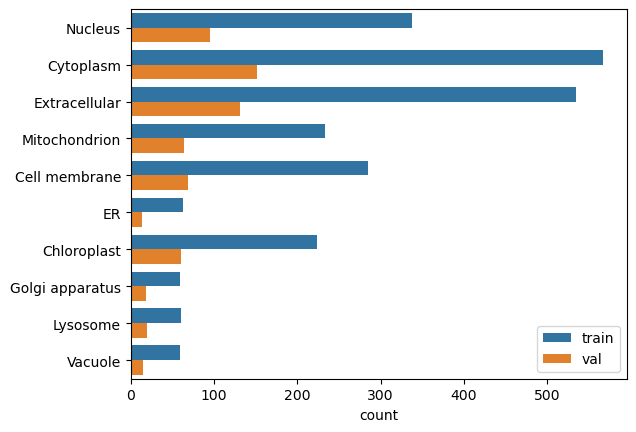

In [13]:
classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell={i:v for i,v in enumerate(classes)}

sns.countplot(y = [ dico_classes_subcell[y] for y in  y_train ] + [ dico_classes_subcell[y] for y in  y_valid ] ,
              hue = ['train']*len(y_train) + ['val']*len(y_valid),
              order = classes )

In [14]:
X_train[0,].shape

(400, 20)

In [15]:
y_train[0,]

6

In [16]:
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()
X_val_tensor = torch.tensor(X_valid).float()
y_val_tensor = torch.tensor(y_valid).long()

# Calculate class weights inversely proportional to their frequencies
class_counts = np.bincount(y_train_tensor.numpy())
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Create a weighted random sampler to handle imbalanced class distribution
weights = class_weights[y_train_tensor]
weighted_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

In [17]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features.unsqueeze(1)  # Add a channel dimension
        #self.labels = labels.unsqueeze(1)      # Reshape labels to (batch_size, 1)
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# Assuming X_train_tensor and y_train_tensor are already defined
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler) # Use the weighted random sampler
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [36]:
class CNN(nn.Module):
    def __init__(self, input_height=400, input_width=20, in_channels=1):
        super(CNN, self).__init__()
        
        # In case of our problem, both N-terminal and C-terminal reisdues are so important, as well as all aminoacids => we use same padding for both width and height
        self.conv_layers = nn.Sequential(
            # Convolutional layer with 'same' padding
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5, 3), stride=1, padding=(2, 1)), # Output: (400, 20)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (200, 10)
            nn.Dropout(0.20),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=(1, 1)), # Output: (200, 10)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (100, 5)
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=(1, 1)), # Output: (100, 5)
            nn.ReLU(),
            nn.Dropout(0.30)
            # No additional pooling to retain dimensionality
        )
        
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 100 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x
model = CNN(input_height=400, input_width=20, in_channels=1).to(device)
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=8000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [19]:
x,y = train_dataset[0]
print(pms.summary(model, x.reshape(1,1,400,20) , show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1     [1, 1, 400, 20]              64              64
            ReLU-2     [1, 4, 400, 20]               0               0
       MaxPool2d-3     [1, 4, 400, 20]               0               0
          Conv2d-4     [1, 4, 200, 10]             296             296
            ReLU-5     [1, 8, 200, 10]               0               0
       MaxPool2d-6     [1, 8, 200, 10]               0               0
          Conv2d-7      [1, 8, 100, 5]           1,168           1,168
            ReLU-8     [1, 16, 100, 5]               0               0
         Flatten-9     [1, 16, 100, 5]               0               0
         Linear-10           [1, 8000]       1,024,128       1,024,128
           ReLU-11            [1, 128]               0               0
         Linear-12            [1, 128]           8,256           8,256
     

In [37]:
def train(dataloader, model, loss_fn, optimizer ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,y) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training
        y = y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


In [38]:
loss = nn.CrossEntropyLoss(weight=class_weights.to(device))

#Try if it works...
for batch, (X,y) in enumerate(train_loader): # for each batch
    print(batch ,"\nfeature shape:", X.shape,"\nlabel shape:", y.shape)
    break
    
with torch.no_grad():
    pred = model(X)
    print("Prediction shape:", pred.shape)
    print( 'avg loss:', loss( pred , y ))

0 
feature shape: torch.Size([64, 1, 400, 20]) 
label shape: torch.Size([64])
Prediction shape: torch.Size([64, 10])
avg loss: tensor(2.3132)


In [57]:
def get_model_balanced_accuracy(model, dataloader):
    Ys = np.array([] , dtype = 'int64')
    Ps = np.array([], dtype = 'int64')

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            predicted_classes = pred.argmax(dim=1)

            Ys = np.concatenate([Ys, y.cpu().numpy()])
            Ps = np.concatenate([Ps, predicted_classes.cpu().numpy()])

    # Calculate the confusion matrix
    cm = confusion_matrix(Ys, Ps)
    # Calculate recall for each class which is true_positive / (true_positive + false_negative)
    recall_per_class = cm.diagonal() / cm.sum(axis=1)
    # Calculate the balanced accuracy which is the average recall per class
    balanced_accuracy = np.mean(recall_per_class)
    
    return balanced_accuracy

def get_model_accuracy(model, dataloader):
    Ys = np.array([] , dtype = 'int64' )  # Assuming labels are integer class indices
    Ps = np.array([], dtype = 'int64' )

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            # Get the predicted class indices
            predicted_classes = pred.argmax(dim=1)

            Ys = np.concatenate([Ys, y.cpu().numpy()])
            Ps = np.concatenate([Ps, predicted_classes.cpu().numpy()])

    return np.mean(Ys == Ps)

def get_model_f1_score_macro(model, dataloader):
    Ys = np.array([] , dtype = 'int64')
    Ps = np.array([], dtype = 'int64')

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            # Get the predicted class indices
            predicted_classes = pred.argmax(dim=1)

            Ys = np.concatenate([Ys, y.cpu().numpy()])
            Ps = np.concatenate([Ps, predicted_classes.cpu().numpy()])

    # Calculate the confusion matrix
    cm = confusion_matrix(Ys, Ps)
    # Calculate precision and recall for each class
    precision_per_class = cm.diagonal() / cm.sum(axis=0)
    recall_per_class = cm.diagonal() / cm.sum(axis=1)
    
    # Handle potential division by zero
    precision_per_class = np.nan_to_num(precision_per_class)
    recall_per_class = np.nan_to_num(recall_per_class)

    # Calculate F1 score for each class
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
    
    # Handle potential division by zero
    f1_per_class = np.nan_to_num(f1_per_class)
    
    # Calculate the macro-averaged F1 score
    macro_f1_score = np.mean(f1_per_class)
    
    return macro_f1_score

In [40]:
model = CNN(input_height=400, input_width=20, in_channels=1).to(device)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 10**-4 ) 

## container to keep the scores across all epochs
train_scores = []
valid_scores = []

early_stopping = EarlyStopping(patience=25, verbose=False)

In [41]:
## naive performance
print( "train accuracy:", get_model_accuracy(model, train_loader) )
print( "valid accuracy:", get_model_accuracy(model, val_loader) )

train accuracy: 0.10152703260420966
valid accuracy: 0.02047244094488189


In [60]:
%%time

epoch = 10

for t in range(epoch):
    echo = t%1==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_loader,model, loss, optimizer, echo = True , echo_batch = True ) )
    valid_scores.append( valid(val_loader, model, loss, echo = True) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 186
Train loss: 0.368036  [   64/ 2423]
Train loss: 0.446544  [  128/ 2423]
Train loss: 0.449238  [  192/ 2423]
Train loss: 0.408482  [  256/ 2423]
Train loss: 0.360249  [  320/ 2423]
Train loss: 0.276742  [  384/ 2423]
Train loss: 0.502864  [  448/ 2423]
Train loss: 0.300409  [  512/ 2423]
Train loss: 0.441352  [  576/ 2423]
Train loss: 0.382987  [  640/ 2423]
Train loss: 0.283904  [  704/ 2423]
Train loss: 0.625424  [  768/ 2423]
Train loss: 0.380931  [  832/ 2423]
Train loss: 0.276378  [  896/ 2423]
Train loss: 0.367083  [  960/ 2423]
Train loss: 0.507815  [ 1024/ 2423]
Train loss: 0.392148  [ 1088/ 2423]
Train loss: 0.537193  [ 1152/ 2423]
Train loss: 0.583678  [ 1216/ 2423]
Train loss: 0.178443  [ 1280/ 2423]
Train loss: 0.333474  [ 1344/ 2423]
Train loss: 0.601556  [ 1408/ 2423]
Train loss: 0.554665  [ 1472/ 2423]
Train loss: 0.338746  [ 1536/ 2423]
Train loss: 0.503880  [ 1600/ 2423]
Train loss: 0.551457  [ 1664/ 2423]
Train loss: 0.352525  [ 1728/ 2423]
Train loss: 0.3905

<All keys matched successfully>

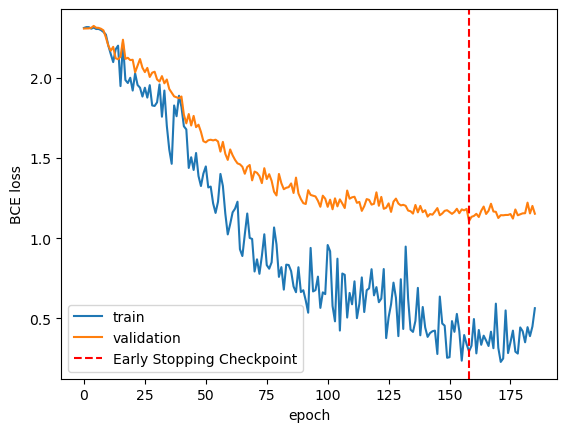

train accuracy: 0.8984729673957903
valid accuracy: 0.7070866141732284

train balanced accuracy: 0.9039448976208918
valid balanced accuracy: 0.663303933953779

train F1 score: 0.9066655395239046
valid F1 score: 0.6469740195268386


In [61]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')
plt.show()

print( "train accuracy:", get_model_accuracy(model, train_loader) )
print( "valid accuracy:", get_model_accuracy(model, val_loader) )

print( "\ntrain balanced accuracy:", get_model_balanced_accuracy(model, train_loader) )
print( "valid balanced accuracy:", get_model_balanced_accuracy(model, val_loader) )

print( "\ntrain F1 score:", get_model_f1_score_macro(model, train_loader) )
print( "valid F1 score:", get_model_f1_score_macro(model, val_loader) )